# EBAC - Regressão II - regressão múltipla

## Tarefa II

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [328]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy


In [330]:
df = pd.read_csv('previsao_de_renda.csv')

In [332]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          15000 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
 15  lo

In [334]:
df

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,log_renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34,8.994711
1,1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15,7.524102
2,2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89,7.720413
3,3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77,8.794942
4,4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97,8.775854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,2016-03-01,16006,F,False,True,0,Empresário,Secundário,Solteiro,Casa,48,13.887671,1.0,7990.58,8.986019
14996,14996,2016-03-01,3722,F,False,True,0,Pensionista,Superior completo,Solteiro,Casa,57,6.013699,1.0,10093.45,9.219642
14997,14997,2016-03-01,6194,F,True,True,0,Assalariado,Superior completo,Casado,Casa,45,7.832877,2.0,604.82,6.404931
14998,14998,2016-03-01,4922,M,True,False,0,Empresário,Superior completo,Casado,Casa,36,4.298630,2.0,3352.27,8.117393


### Rotinas anteiores: 

Ajuste do modelo para prever log(renda) considerando todas as covariáveis disponíveis.

Removação de variáveis menos significantes.


In [338]:
# Tratando valores ausentes em 'tempo_emprego':
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].median())

# Criando variável logarítmica da renda:
df['log_renda'] = np.log(df['renda'])

# Definindo a fórmula para o modelo incluindo todas as variáveis:
# Usando Patsy para criar as variáveis dummy e excluir a categoria de referência:
formula = 'log_renda ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia'

# Construindo o design matrix e a resposta usando Patsy:
y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')

# Ajustando o modelo de regressão linear múltipla:
model = sm.OLS(y, X).fit()

# Resumo do modelo:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     333.6
Date:                Sun, 28 Jul 2024   Prob (F-statistic):               0.00
Time:                        20:28:54   Log-Likelihood:                -16213.
No. Observations:               15000   AIC:                         3.248e+04
Df Residuals:                   14975   BIC:                         3.267e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [340]:
# Preenchendo valores ausentes:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].median())

# Criando a variável logarítmica da renda:
df['log_renda'] = np.log(df['renda'])

# Definindo a fórmula inicial para o modelo:
formula_inicial = 'log_renda ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia'

# Construindo a design matrix e a resposta usando Patsy:
y, X = patsy.dmatrices(formula_inicial, data=df, return_type='dataframe')

# Ajustando o modelo de regressão linear múltipla:
model_inicial = sm.OLS(y, X).fit()

# Resumo do modelo inicial:
print("Resumo do Modelo Inicial:")
print(model_inicial.summary())

# Atualizando a fórmula para excluir as variáveis 'educacao' e 'tipo_residencia':
formula_reduzida = formula_inicial.replace('educacao + ', '')
formula_reduzida = formula_reduzida.replace(' + educacao', '')
formula_reduzida = formula_reduzida.replace('tipo_residencia + ', '')
formula_reduzida = formula_reduzida.replace(' + tipo_residencia', '')

# Construindo a design matrix e a resposta usando Patsy:
y_reduzido, X_reduzido = patsy.dmatrices(formula_reduzida, data=df, return_type='dataframe')

# Ajustando o modelo reduzido (sem 'educacao' e 'tipo_residencia'):
model_reduzido = sm.OLS(y_reduzido, X_reduzido).fit()

# Resumo do modelo reduzido:
print("\nResumo do Modelo com 'educacao' e 'tipo_residencia' removidas:")
print(model_reduzido.summary())


Resumo do Modelo Inicial:
                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     333.6
Date:                Sun, 28 Jul 2024   Prob (F-statistic):               0.00
Time:                        20:28:54   Log-Likelihood:                -16213.
No. Observations:               15000   AIC:                         3.248e+04
Df Residuals:                   14975   BIC:                         3.267e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [342]:
# Tratando valores ausentes em 'tempo_emprego':
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].median())

# Criando a variável logarítmica da renda:
df['log_renda'] = np.log(df['renda'])

# Definindo a fórmula inicial para o modelo:
formula_inicial = (
    'log_renda ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + '
    'tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + '
    'qt_pessoas_residencia'
)

# Construindo a design matrix e a resposta usando Patsy:
y, X = patsy.dmatrices(formula_inicial, data=df, return_type='dataframe')

# Ajustando o modelo de regressão linear múltipla:
model_inicial = sm.OLS(y, X).fit()

# Resumo do modelo inicial:
print("Resumo do Modelo Inicial:")
print(model_inicial.summary())

# Atualizando a fórmula para excluir as variáveis 'educacao' e 'tipo_residencia':
formula_reduzida = formula_inicial.replace('educacao + ', '')
formula_reduzida = formula_reduzida.replace(' + educacao', '')
formula_reduzida = formula_reduzida.replace('tipo_residencia + ', '')
formula_reduzida = formula_reduzida.replace(' + tipo_residencia', '')

# Construindo a design matrix e a resposta usando Patsy:
y_reduzido, X_reduzido = patsy.dmatrices(formula_reduzida, data=df, return_type='dataframe')

# Ajustando o modelo reduzido (sem 'educacao' e 'tipo_residencia'):
model_reduzido = sm.OLS(y_reduzido, X_reduzido).fit()

# Resumo do modelo reduzido:
print("\nResumo do Modelo com 'educacao' e 'tipo_residencia' removidas:")
print(model_reduzido.summary())

# Atualizando a fórmula para excluir também as variáveis 'sexo' e 'estado_civil':
formula_final = formula_reduzida.replace('sexo + ', '')
formula_final = formula_final.replace(' + sexo', '')
formula_final = formula_final.replace('estado_civil + ', '')
formula_final = formula_final.replace(' + estado_civil', '')

# Construindo a design matrix e a resposta usando Patsy:
y_final, X_final = patsy.dmatrices(formula_final, data=df, return_type='dataframe')

# Ajustando o modelo final (sem 'sexo', 'estado_civil', 'educacao' e 'tipo_residencia'):
model_final = sm.OLS(y_final, X_final).fit()

# Resumo do modelo final:
print("\nResumo do Modelo com 'sexo', 'estado_civil', 'educacao' e 'tipo_residencia' removidas:")
print(model_final.summary())

# Comparando o modelo inicial e o modelo final:
print("\nComparação entre Modelo Inicial e Modelo Final:")
print("R² do modelo inicial:", model_inicial.rsquared)
print("R² do modelo final:", model_final.rsquared)
print("MSE do modelo inicial:", np.mean(model_inicial.resid**2))
print("MSE do modelo final:", np.mean(model_final.resid**2))

Resumo do Modelo Inicial:
                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     333.6
Date:                Sun, 28 Jul 2024   Prob (F-statistic):               0.00
Time:                        20:28:55   Log-Likelihood:                -16213.
No. Observations:               15000   AIC:                         3.248e+04
Df Residuals:                   14975   BIC:                         3.267e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

____________

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na base de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

### 1. Separar a base em treinamento e teste

In [351]:
# Separando variáveis preditoras e variável alvo:
X = df.drop(columns=['log_renda'])
y = df['log_renda']

# Dividindo a base em treinamento (75%) e teste (25%):
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)
print("Tamanho do conjunto de treinamento:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)


Tamanho do conjunto de treinamento: (11250, 15)
Tamanho do conjunto de teste: (3750, 15)


### 2. Regressão Ridge

In [353]:
# Identificando as variáveis categóricas e numéricas:
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# Criando transformadores para pré-processar as variáveis categóricas e numéricas:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

# Definindo os valores de alpha a serem testados:
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

# Inicializando variáveis para armazenar o melhor modelo e o menor MSE:
best_alpha = None
best_mse = float('inf')
best_model = None

# Avaliando o modelo Ridge para diferentes valores de alpha:
for alpha in alphas:
    # Criando o pipeline:
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=alpha))
    ])
    
    # Ajustando o modelo:
    model.fit(X_train, y_train)
    
    # Fazendo previsões:
    y_pred = model.predict(X_test)
    
    # Calculando o MSE:
    mse = mean_squared_error(y_test, y_pred)
    print(f"Alpha: {alpha}, MSE: {mse}")
    
    # Verificando se o MSE é o menor encontrado:
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_model = model

print(f"\nMelhor modelo encontrado com alpha = {best_alpha} e MSE = {best_mse}")


Alpha: 0, MSE: 0.29606898673056814
Alpha: 0.001, MSE: 0.296068848632832
Alpha: 0.005, MSE: 0.2960688751185087
Alpha: 0.01, MSE: 0.2960688708269005
Alpha: 0.05, MSE: 0.2960692002885668
Alpha: 0.1, MSE: 0.29606996118548135

Melhor modelo encontrado com alpha = 0.001 e MSE = 0.296068848632832


### 3. Regressão LASSO

In [355]:
# Inicializando variáveis para armazenar o melhor modelo LASSO e o menor MSE:
best_alpha_lasso = None
best_mse_lasso = float('inf')
best_model_lasso = None

# Avaliando o modelo LASSO para diferentes valores de alpha:
for alpha in alphas:
    # Criando o pipeline para LASSO:
    model_lasso = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', Lasso(alpha=alpha, random_state=100))
    ])
    
    # Ajustando o modelo LASSO:
    model_lasso.fit(X_train, y_train)
    
    # Fazendo previsões:
    y_pred_lasso = model_lasso.predict(X_test)
    
    # Calculando o MSE:
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    print(f"Alpha (LASSO): {alpha}, MSE: {mse_lasso}")
    
    # Verificando se o MSE é o menor encontrado:
    if mse_lasso < best_mse_lasso:
        best_mse_lasso = mse_lasso
        best_alpha_lasso = alpha
        best_model_lasso = model_lasso

print(f"\nMelhor modelo LASSO encontrado com alpha = {best_alpha_lasso} e MSE = {best_mse_lasso}")

# Comparando os melhores modelos Ridge e LASSO:
print("\nComparação entre Ridge e LASSO:")
print(f"Melhor Ridge com alpha = {best_alpha} e MSE = {best_mse}")
print(f"Melhor LASSO com alpha = {best_alpha_lasso} e MSE = {best_mse_lasso}")


C:\Users\User\anaconda3\Lib\site-packages\sklearn\pipeline.py:405: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1772.6175520299237, tolerance: 0.8811835151031461
  model = cd_fast.sparse_enet_coordinate_descent(


Alpha (LASSO): 0, MSE: 0.2960438971798723
Alpha (LASSO): 0.001, MSE: 0.2961651546186131
Alpha (LASSO): 0.005, MSE: 0.2973507248572992
Alpha (LASSO): 0.01, MSE: 0.29890568759043384
Alpha (LASSO): 0.05, MSE: 0.316508011978305
Alpha (LASSO): 0.1, MSE: 0.35288471478792477

Melhor modelo LASSO encontrado com alpha = 0 e MSE = 0.2960438971798723

Comparação entre Ridge e LASSO:
Melhor Ridge com alpha = 0.001 e MSE = 0.296068848632832
Melhor LASSO com alpha = 0 e MSE = 0.2960438971798723


#### Análise:

Embora a diferença não seja muito grande, percebemos que o método LASSO é o melhor.

### 4. Modelo Stepwise

Instalando  método direto para stepwise:

In [357]:
!pip install mlxtend 


In [359]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Identificando variáveis categóricas e numéricas:
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# Criando transformadores para variáveis categóricas e numéricas:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

# Dividindo o dataset em treino e teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criando o modelo stepwise:
sfs = SFS(LinearRegression(), 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring='r2', 
          cv=5)

# Criando o pipeline com o pré-processador e o modelo stepwise:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', sfs),
    ('regressor', LinearRegression())
])

# Ajustando o modelo stepwise:
pipeline.fit(X_train, y_train)

# Avaliando o R² na base de teste:
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² na base de teste para o modelo stepwise: {r2}")


R² na base de teste para o modelo stepwise: 0.6536251437815069


### 5. Comparando os parâmetros e avaliando eventuais diferenças. 

O melhor modelo seria: Stepwise, por calcular R-quadrado acima de 5.

### 6. Melhorando o $R^2$ na base de testes:

#### Random Forests:

In [370]:
from sklearn.ensemble import RandomForestRegressor

# Criando o pipeline com Random Forests:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=100))
])

# Ajustando o modelo Random Forests:
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"R² na base de teste para o modelo Random Forests: {r2_rf}")


R² na base de teste para o modelo Random Forests: 0.9999965507587507


#### Gradient Boosting:

In [373]:
from sklearn.ensemble import GradientBoostingRegressor

# Criando o pipeline com Gradient Boosting:
pipeline_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=100))
])

# Ajustando o modelo Gradient Boosting:
pipeline_gb.fit(X_train, y_train)
y_pred_gb = pipeline_gb.predict(X_test)
r2_gb = r2_score(y_test, y_pred_gb)
print(f"R² na base de teste para o modelo Gradient Boosting: {r2_gb}")


R² na base de teste para o modelo Gradient Boosting: 0.9998912965878648


Percebemos que os dois modelos acima retornaram R-quadrado muito satisfatório.

### 7. Ajustando a árvore de regressão e melhorando o $R^2$:

In [396]:
# Ajustando a árvore de decisão para regressão:
max_depths = [3, 5, 7, 10]  # Profundidades diferentes para testar:
best_depth = None
best_r2 = float('-inf')
best_model = None

for depth in max_depths:
    # Criando o modelo de árvore de decisão com a profundidade especificada:
    model_tree = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(max_depth=depth, random_state=100))
    ])
    
    # Ajustando o modelo:
    model_tree.fit(X_train, y_train)
    
    # Fazendo previsões:
    y_pred_tree = model_tree.predict(X_test)
    
    # Calculando o R²:
    r2_tree = r2_score(y_test, y_pred_tree)
    print(f"Profundidade: {depth}, R²: {r2_tree}")
    
    # Verificando se o R² é o melhor encontrado:
    if r2_tree > best_r2:
        best_r2 = r2_tree
        best_depth = depth
        best_model = model_tree

print(f"\nMelhor modelo encontrado com profundidade = {best_depth} e R² = {best_r2}")


Profundidade: 3, R²: 0.9663030930412311
Profundidade: 5, R²: 0.9974491898284212
Profundidade: 7, R²: 0.9998423778213951
Profundidade: 10, R²: 0.999984513853029

Melhor modelo encontrado com profundidade = 10 e R² = 0.999984513853029


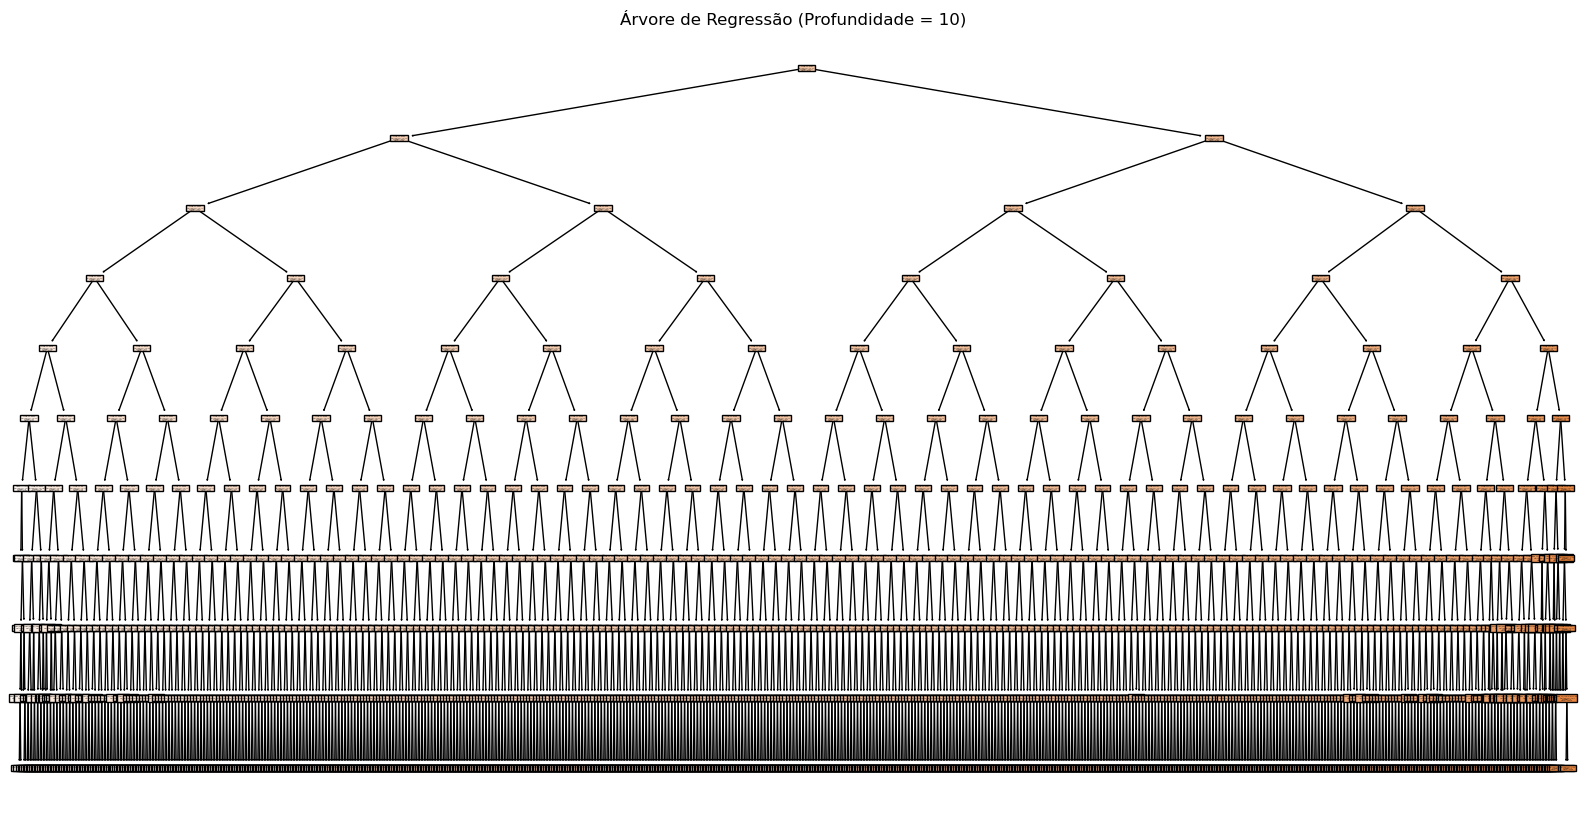

In [402]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

def get_feature_names(preprocessor):
    feature_names = []
    
    if 'num' in preprocessor.named_transformers_:
        num_transformer = preprocessor.named_transformers_['num']
        feature_names.extend(num_transformer.get_feature_names_out())
    
    if 'cat' in preprocessor.named_transformers_:
        cat_transformer = preprocessor.named_transformers_['cat']
        feature_names.extend(cat_transformer.get_feature_names_out())
    
    return feature_names

feature_names = get_feature_names(preprocessor)

# Visualizando a árvore de regressão com a melhor profundidade:
best_tree_model = best_model.named_steps['regressor']

# Plotando a árvore de regressão:
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(best_tree_model, feature_names=feature_names, filled=True, ax=ax)
plt.title(f'Árvore de Regressão (Profundidade = {best_depth})')
plt.show()
